In [1]:
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from scipy.stats import hypergeom
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

# Enrichement

#### Set parameters

In [3]:
namespace = 'CC'
lb_GO = 5
ub_GO = 500
min_lvl = 0
max_lvl = 100

#### Load and parse annotation data

In [4]:
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")

annotation_df = all_CC_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_{namespace}_sc.csv")

go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (lb_GO <= len(annotation_df[annotation_df.GO_ID == go_id]) <= ub_GO and
                               min_lvl <= go_dag[go_id].level <= max_lvl)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

/home/clusterduck123/Desktop/git/supplements/data/raw_data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


#### Define convenient dictionaries

In [5]:
# Conversion dictionaries
int2GO = dict(enumerate(GO_population))
GO2int = dict(zip(int2GO.values(), int2GO.keys()))

GO2genes = {go_id:set(annotation_df.Systematic_ID[annotation_df.GO_ID == go_id])
                for go_id in GO_population}

gene2GOs = {gene :set(annotation_df.GO_ID[annotation_df.Systematic_ID == gene]) 
                for gene in PPI}

## Here we GO

#### Functions

In [6]:
def gene_enriched_in_cluster(gene, cluster, enrichment):
    return bool(gene2GOs[gene] & set(GO_index[enrichment[cluster]]))

def get_enrichment_df(alpha, p_values):
    m = p_values.size
    c = np.log(m) + np.euler_gamma + 1/(2*m)
    sorted_p_values = np.sort(p_values.values.flatten())
    for k,P_k in enumerate(sorted_p_values,1):
        if P_k > k/(m*c) * alpha:
            break
    threshold = sorted_p_values[k-2]
    return p_values_df < threshold

def get_number_of_max_runs(GV, distance, MAX_CLUSTERS = 100):
    runs = max(int(run) for run,species,db,ncluster_txt in 
             map(partial(str.split, sep='_'), os.listdir(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}"))
                if int(ncluster_txt.split('.')[0]) == MAX_CLUSTERS-1)
    return runs

#### Cluster independent arrays

In [7]:
list_of_success_states = list(GO2genes.values())
array_of_total_successes = np.array(list(map(len,list_of_success_states))).reshape(-1,1)

In [8]:
alpha = 0.05
MIN_CLUSTERS = 2
MAX_CLUSTERS = 50

cluster_coverages = defaultdict(pd.DataFrame)
GO_coverages      = defaultdict(pd.DataFrame)
gene_coverages    = defaultdict(pd.DataFrame)

In [9]:
for method in ['GDV_similarity']:
    
    GV, distance = method.split('_')
    runs = min(get_number_of_max_runs(GV, distance, MAX_CLUSTERS), 10)

    for run in range(runs+1):
        
        t1 = time.time()
        print(f"{GV}-{distance} {run+1}")
        
        cluster_coverage_arr = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)
        GO_coverage_arr      = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)
        gene_coverage_arr    = np.zeros(MAX_CLUSTERS-MIN_CLUSTERS)
        
        for i, n_clusters in enumerate(range(2, MAX_CLUSTERS)):
            

            with open(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}/{run}_sc_BioGRID_{n_clusters}.txt", 'r') as f:
                    list_of_experiments = [set(line.split()) for line in f] 

            clusters = dict(enumerate(list_of_experiments))

            # For each GO term and cluster we get an experiment 
            array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                                for success_states in list_of_success_states])



            K = array_of_total_successes             # defined in section 'Preparation'
            n = list(map(len, list_of_experiments))  # cluster lengths
            k = array_of_observed_successes          # number of annotated genes found in cluster
            N = sum(n)                               # PPI size, i.e. number of all genes that appear in a cluster

            # scipy has a really messed up nomeclature... 
            p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
            p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
            GO_index = p_values_df.index

            m = p_values_array.size
            enrichment_df = get_enrichment_df(alpha,p_values_df)
            
            cluster_coverage_arr[i] = sum(enrichment_df.any())      /n_clusters
            GO_coverage_arr[     i] = sum(enrichment_df.any(axis=1))/len(GO_population)
            gene_coverage_arr[   i] = sum(1 for cluster in clusters for gene in clusters[cluster] 
                                                if gene_enriched_in_cluster(gene, cluster, enrichment_df))/N

            t2 = time.time()
            print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
        cluster_coverages[method][run] = cluster_coverage_arr
        GO_coverages[method][run]      = GO_coverage_arr
        gene_coverages[method][run]    = gene_coverage_arr
    print()

GDV-similarity 1
GDV-similarity 2
GDV-similarity 3
GDV-similarity 4
GDV-similarity 5
GDV-similarity 6
GDV-similarity 7
GDV-similarity 8
GDV-similarity 9
GDV-similarity 10
GDV-similarity 11
49: 19.69sec


# Plots

In [12]:
plot_methods = ['GDV_similarity']

name2string = {'GCV_tvd':'TVD', 'GCV_hellinger':'GCV_{hell}', 'GDV_similarity':'Tijana',
               
               'GDV_euclidean'  :'GDV_{eucl}'  , 'GDV_zscore_euclidean'  :'GDV_{z-eucl}'  , 
               'GDV_cityblock'  :'GDV_{city}'  , 'GDV_zscore_cityblock'  :'GDV_{z-city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GDV_zscore_seuclidean' :'GDV_{z-seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GDV_zscore_cosine'     :'GDV_{z-cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GDV_zscore_correlation':'GDV_{z-cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GDV_zscore_sqeuclidean':'GDV_{z-eucl^2}',
               'GDV_chebyshev'  :'GDV_{cheby}' , 'GDV_zscore_chebyshev'  :'GDV_{z-cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GDV_zscore_canberra'   :'GDV_{z-can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GDV_zscore_braycurtis' :'GDV_{z-bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GDV_zscore_mahalanobis':'GDV_{z-mahala}',
               
               'GCV_euclidean'  :'GCV_{eucl}'  , 'GCV_zscore_euclidean'  :'GCV_{z-eucl}'  , 
               'GCV_cityblock'  :'GCV_{city}'  , 'GCV_zscore_cityblock'  :'GCV_{z-city}'  , 
               'GCV_seuclidean' :'GCV_{seucl}' , 'GCV_zscore_seuclidean' :'GCV_{z-seucl}' ,
               'GCV_cosine'     :'GCV_{cos}'   , 'GCV_zscore_cosine'     :'GCV_{z-cos}'   ,
               'GCV_correlation':'GCV_{cor}'   , 'GCV_zscore_correlation':'GCV_{z-cor}'   ,
               'GCV_sqeuclidean':'GCV_{eucl^2}', 'GCV_zscore_sqeuclidean':'GCV_{z-eucl^2}',
               'GCV_chebyshev'  :'GCV_{cheby}' , 'GCV_zscore_chebyshev'  :'GCV_{z-cheby}' ,
               'GCV_canberra'   :'GCV_{can}'   , 'GCV_zscore_canberra'   :'GCV_{z-can}'   ,
               'GCV_braycurtis' :'GCV_{bray}'  , 'GCV_zscore_braycurtis' :'GCV_{z-bray}'  ,
               'GCV_mahalanobis':'GCV_{mahala}', 'GCV_zscore_mahalanobis':'GCV_{z-mahala}',
              
              'gGCV_euclidean'  :'new GCV_{eucl}'  , 'GCV_zscore_euclidean'  :'GCV_{z-eucl}'  ,
              'gGCV_cityblock'  :'new GCV_{city}'  , 'GCV_zscore_cityblock'  :'GCV_{z-city}'  ,
              'gGCV_seuclidean' :'new GCV_{seucl}' , 'GCV_zscore_seuclidean' :'GCV_{z-seucl}' ,
              'gGCV_cosine'     :'new GCV_{cos}'   , 'GCV_zscore_cosine'     :'GCV_{z-cos}'   ,
              'gGCV_correlation':'new GCV_{cor}'   , 'GCV_zscore_correlation':'GCV_{z-cor}'   ,
              'gGCV_sqeuclidean':'new GCV_{eucl^2}', 'GCV_zscore_sqeuclidean':'GCV_{z-eucl^2}',
              'gGCV_chebyshev'  :'new GCV_{cheby}' , 'GCV_zscore_chebyshev'  :'GCV_{z-cheby}' ,
              'gGCV_canberra'   :'new GCV_{can}'   , 'GCV_zscore_canberra'   :'GCV_{z-can}'   ,
              'gGCV_braycurtis' :'new GCV_{bray}'  , 'GCV_zscore_braycurtis' :'GCV_{z-bray}'  ,
              'gGCV_mahalanobis':'new GCV_{mahala}', 'GCV_zscore_mahalanobis':'GCV_{z-mahala}',}

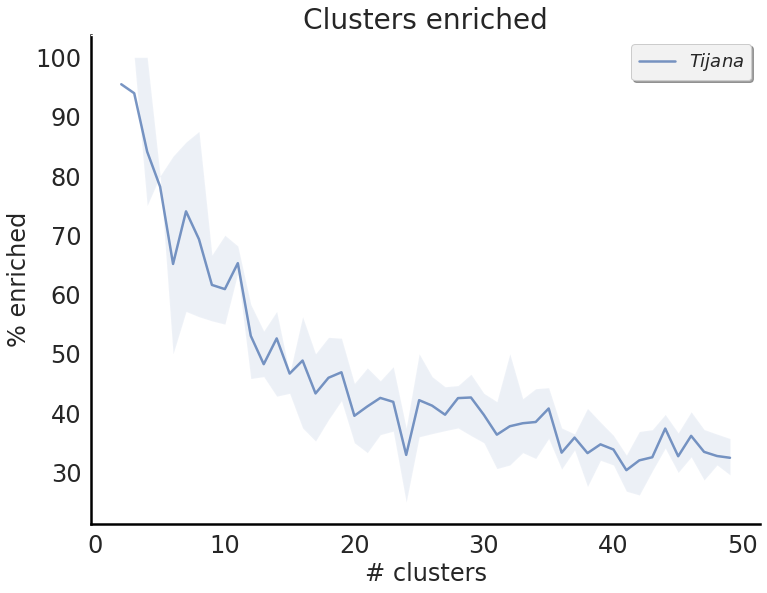

In [13]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(range(2,MAX_CLUSTERS), 100*cluster_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*cluster_coverages[method].T.quantile(0.25), 
                     100*cluster_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title('Clusters enriched', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

In [ ]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(range(2,MAX_CLUSTERS), 100*GO_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*GO_coverages[method].T.quantile(0.25), 
                     100*GO_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title('GO-terms enriched', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

In [ ]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    ax.plot(range(2,MAX_CLUSTERS), 100*gene_coverages[method].T.mean(), 
            label=f'${name2string[method]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     100*gene_coverages[method].T.quantile(0.25), 
                     100*gene_coverages[method].T.quantile(0.75), 
                     alpha=0.1,);
    ax.set_title('Genes enriched', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

# Test

In [16]:
p_values_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
GO:0006518,0.212222,0.444652,0.002369,0.033161,0.332357,1.000000,0.104190,1.0,0.240645,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,0.006103,0.967245,0.869226,0.167601,0.388479,0.226563,...,1.000000,1.000000,1.000000,1.000000,1.0,0.268052,1.000000,0.874227,0.914319,0.554955,0.474535,1.0,1.000000,0.091029,1.000000,1.000000,1.000000,0.413087,0.681011,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0010906,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.030018,1.0,1.000000,1.000000,1.000000,0.082808,1.000000,1.000000,0.044700,1.000000,1.0,1.000000,1.0,1.000000,0.854245,0.867170,1.000000,1.000000,1.000000,...,1.000000,0.002497,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.679870,0.200888,1.000000,1.0,0.004900,0.132818,1.000000,1.000000,1.000000,1.000000,1.000000,0.204967,1.0,1.0,1.0,1.0,1.000000
GO:0009063,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.902269,0.016041,1.000000,0.755202,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.149013,0.747268,0.237227,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.013289,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0006357,0.221295,0.375070,0.478943,0.756444,0.186808,0.171409,0.005409,1.0,0.654330,0.015983,0.068285,0.325202,0.061495,0.008307,0.121763,1.000000,1.0,0.121763,1.0,1.000000,0.984280,0.999756,0.507302,0.195820,0.628929,...,0.559303,0.015983,0.321457,0.013663,1.0,1.000000,0.789651,0.501092,0.747984,0.000025,0.214059,1.0,1.000000,0.038624,0.789651,0.121763,0.677996,0.317613,0.246998,0.822892,1.0,1.0,1.0,1.0,0.246473
GO:0030838,1.000000,1.000000,1.000000,1.000000,1.000000,0.065100,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000147,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.375377,1.000000,1.000000,1.0,0.043173,1.000000,0.000909,1.000000,1.000000,0.059166,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0001731,1.000000,1.000000,1.000000,0.053239,1.000000,0.043870,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.030345,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0001079,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.070425,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,0.628368,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.047895,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0071940,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.066483,1.0,1.000000,1.0,1.000000,0.011734,0.689246,1.000000,1.000000,1.000000,...,1.000000,0.121090,1.000000,1.000000,1.0,1.000000,1.000000,0.248691,0.567314,1.000000,1.000000,1.0,0.165395,0.214325,1.000000,1.000000,1.000000,0.221081,0.098157,1.000000,1.0,1.0,1.0,1.0,1.000000
GO:0043409,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,0.548720,0.773572,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00

In [28]:
len(population)

5538

In [20]:
with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/sc_BioGRID_all_hell_2.txt", 'r') as f:
    list_of_experiments = [set(line.split()) for line in f] 

clusters = dict(enumerate(list_of_experiments))

# For each GO term and cluster we get an experiment 
array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                    for success_states in list_of_success_states])



K = array_of_total_successes             # defined in section 'Preparation'
n = list(map(len, list_of_experiments))  # cluster lengths
k = array_of_observed_successes          # number of annotated genes found in cluster
N = sum(n)                               # PPI size, i.e. number of all genes that appear in a cluster

# scipy has a really messed up nomeclature... 
p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
GO_index = p_values_df.index

m = p_values_array.size
enrichment_dfs = {confidence:get_enrichment_df(alpha,p_values_df) 
                          for confidence, alpha in confidences.items()}

In [21]:
N

5726